## Assignment 2: Time Series Forecasting

### Akshita Sharma | a1902331

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your data
file_path = 'energydata_complete.csv'
data = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
data = data.asfreq('10min') 

The code above imports libraries necessary for data handling and visualization (pandas and matplotlib.pyplot) and for time series analysis (seasonal_decompose from statsmodels). It then loads a CSV file named energydata_complete.csv into a pandas DataFrame, parsing the 'date' column as datetime objects and setting it as the index. Finally, the data is resampled to a fixed 10-minute frequency using asfreq('10min'), aligning the dataset to consistent 10-minute intervals without specifying any method for handling missing timestamps.

In [93]:
##The code uses two common pandas DataFrame methods to provide a quick summary and a preview of the dataset

print(data.info()) #helps in understanding the structure and attributes of the data
print(data.head()) #useful for a preliminary check of data contents and format

#Data was not explicitly checked for null values as it was mentioned in the description that no null or missing values are present in the data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Freq: 10min
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18 

### 2. Analyse and visualise the data

In [8]:
#imports for visualising
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

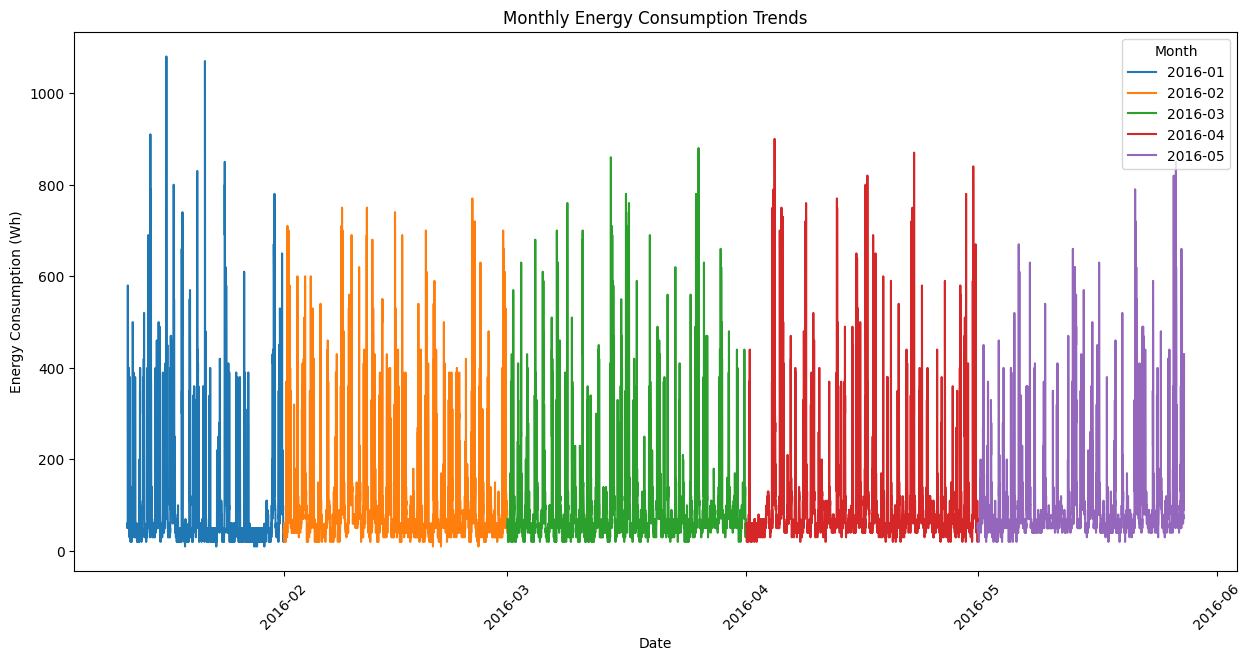

In [9]:
# Creating a plot
fig, ax = plt.subplots(figsize=(15, 7))

# Defining the colormap
cmap = plt.get_cmap("tab10")  # This colormap will provide distinct colors for up to 10 different lines

# Looping through each unique month and plot data for that month
unique_months = data.index.to_period('M').unique()
for i, month in enumerate(unique_months):
    # Selecting the data for the month
    monthly_data = data[data.index.to_period('M') == month]
    ax.plot(monthly_data.index, monthly_data['Appliances'], label=month.strftime('%Y-%m'), color=cmap(i))

# Setting title and labels
ax.set_title('Monthly Energy Consumption Trends')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (Wh)')

# Rotating date labels for better readability
plt.xticks(rotation=45)
plt.legend(title='Month', loc='upper right')

# Improving formatting of dates on the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

The above plot visualizes monthly energy consumption trends over a period of time. The plot depicts the energy consumption in watt-hours (Wh) for each month, with each month represented by a different color. 

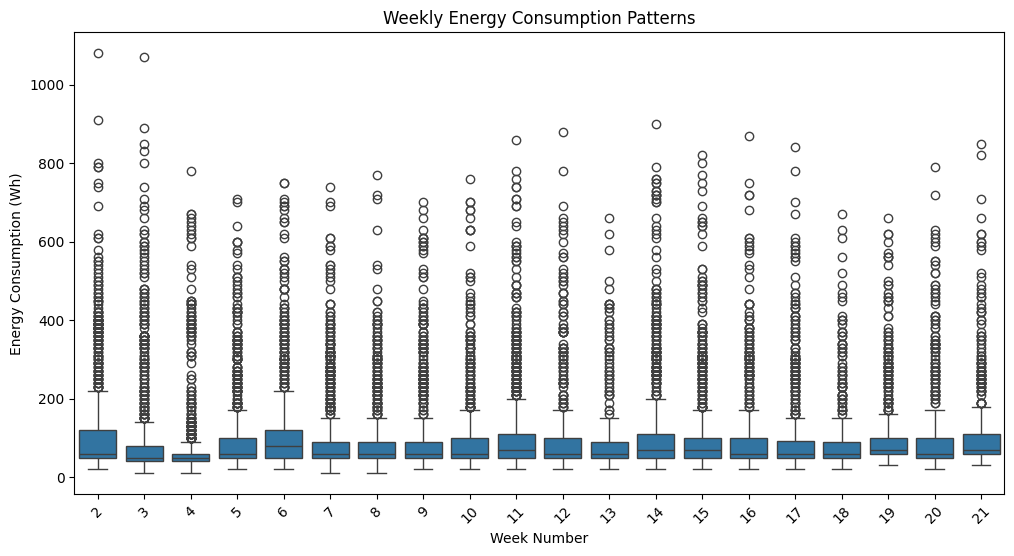

In [87]:
# Extract week number from the date index
data['week'] = data.index.isocalendar().week

# Plotting weekly data
plt.figure(figsize=(12, 6))
sns.boxplot(x='week', y='Appliances', data=data)
plt.title('Weekly Energy Consumption Patterns')
plt.xlabel('Week Number')
plt.ylabel('Energy Consumption (Wh)')
plt.xticks(rotation=45)  # Rotating labels for better readability
plt.show()

Each box represents the distribution of energy consumption for a specific week. The plot allows for easy comparison of median energy consumption across weeks, variability within each week through the spread of the quartiles, and identification of outliers.
The presence of outliers indicates weeks with unusual spikes or drops in energy consumption.

In [15]:
#import for feature selection

from sklearn.feature_selection import SelectKBest, f_regression

The code below uses SelectKBest with f_regression to select the top 5 features that have the highest correlation with the target variable ('Appliances'). These features are likely good predictors for the model based on their relationship with the consumption of appliances.

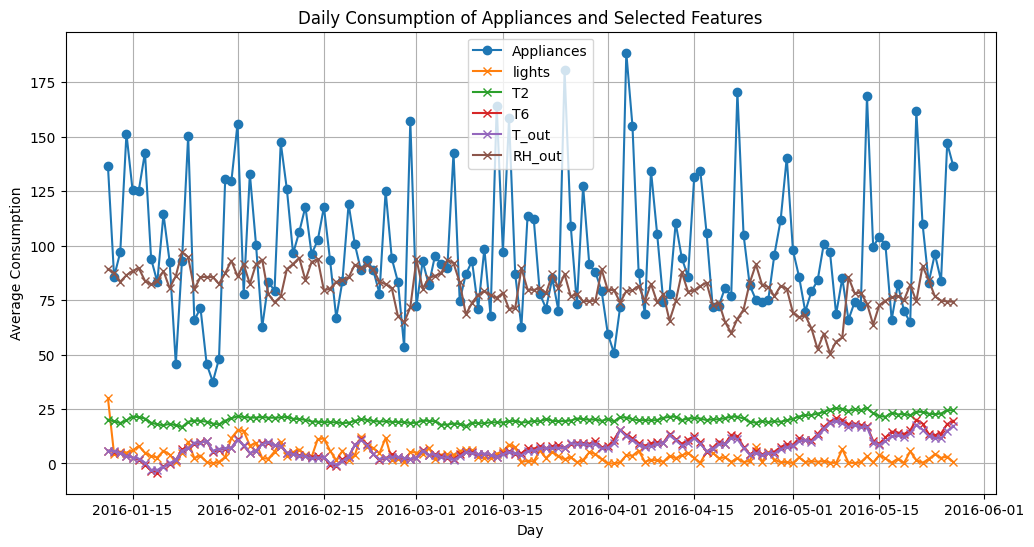

In [94]:
# 'Appliances' is the target and the rest are features
X = data.drop('Appliances', axis=1)  # Features
y = data['Appliances']  # Target

# Feature selection
selector = SelectKBest(score_func=f_regression, k=5) 
X_new = selector.fit_transform(X, y)

# Get the boolean mask of the selected features
mask = selector.get_support() 

# Filter the original feature DataFrame to retain selected features only
selected_features = X.columns[mask]
dropped_features = X.columns[~mask]  # Inverting the mask to get dropped features

# Drop non-selected features from the original DataFrame
data_reduced = data.drop(dropped_features, axis=1)

# Include 'Appliances' back into the data for plotting if it was removed
data_reduced['Appliances'] = y

# Resample the reduced data to daily frequency using the mean as the aggregation function
data_daily = data_reduced.resample('d').mean()

# Plotting the 'Appliances' and all selected features
plt.figure(figsize=(12, 6))
plt.plot(data_daily.index, data_daily['Appliances'], label='Appliances', marker='o')

# Loop through all selected features for plotting
for feature in selected_features:
    plt.plot(data_daily.index, data_daily[feature], label=feature, marker='x')

# Adding titles and labels
plt.title('Daily Consumption of Appliances and Selected Features')
plt.xlabel('Day')
plt.ylabel('Average Consumption')
plt.legend()

# Showing the grid
plt.grid(True)

# Displaying the plot
plt.show()

The plot shows the daily average consumption (in watt-hours) of 'Appliances' as the primary series, with other lines representing the selected features. These features could include environmental variables like temperature and humidity, as indicated by labels such as T2, T6, T_out, and RH_out. The 'Appliances' line (blue with circle markers) displays significant variability, indicating days with notably high or low average consumption. This variability can be influenced by daily usage patterns, external conditions, or other factors. The selected features show more stable patterns, with some gradual changes that might correspond to environmental factors. For example, outdoor temperature ('T_out') could show seasonal variation affecting appliance use.

In [17]:
#import for scaling
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected features
scaled_features = scaler.fit_transform(data_daily[selected_features])

# Replace the original values with the scaled values in the DataFrame
data_daily_scaled = data_daily.copy()
data_daily_scaled[selected_features] = scaled_features

# Optionally, scale the target variable if necessary
data_daily_scaled['Appliances'] = scaler.fit_transform(data_daily[['Appliances']])

The above code is used to scale the selected features and the target variable in a dataset using the MinMaxScaler from scikit-learn. This process normalizes the dataset features to a specific range, typically [0, 1], which is necessary for optimizing the performance of the algorithms to be trained and tested below

In [19]:
data_daily_scaled.head()

,Appliances,lights,T2,T6,T_out,RH_out
date,,,,,,
2016-01-11,0.656552,1.000000,0.399626,0.405019,0.397145,0.832970
2016-01-12,0.319080,0.141204,0.300877,0.383403,0.381175,0.794650
2016-01-13,0.394023,0.180556,0.214568,0.368604,0.349379,0.706803
2016-01-14,0.754023,0.166667,0.351727,0.309193,0.285508,0.771478
2016-01-15,0.581609,0.199074,0.560163,0.276045,0.251144,0.813650


The code below is used for detailed visualization of the relationship between appliance consumption and various other features on a daily basis, with each feature getting its own subplot for direct comparison. This visualization helps us in analyzing how different variables track with or diverge from appliance usage over time, especially when these variables are key factors influencing energy consumption.

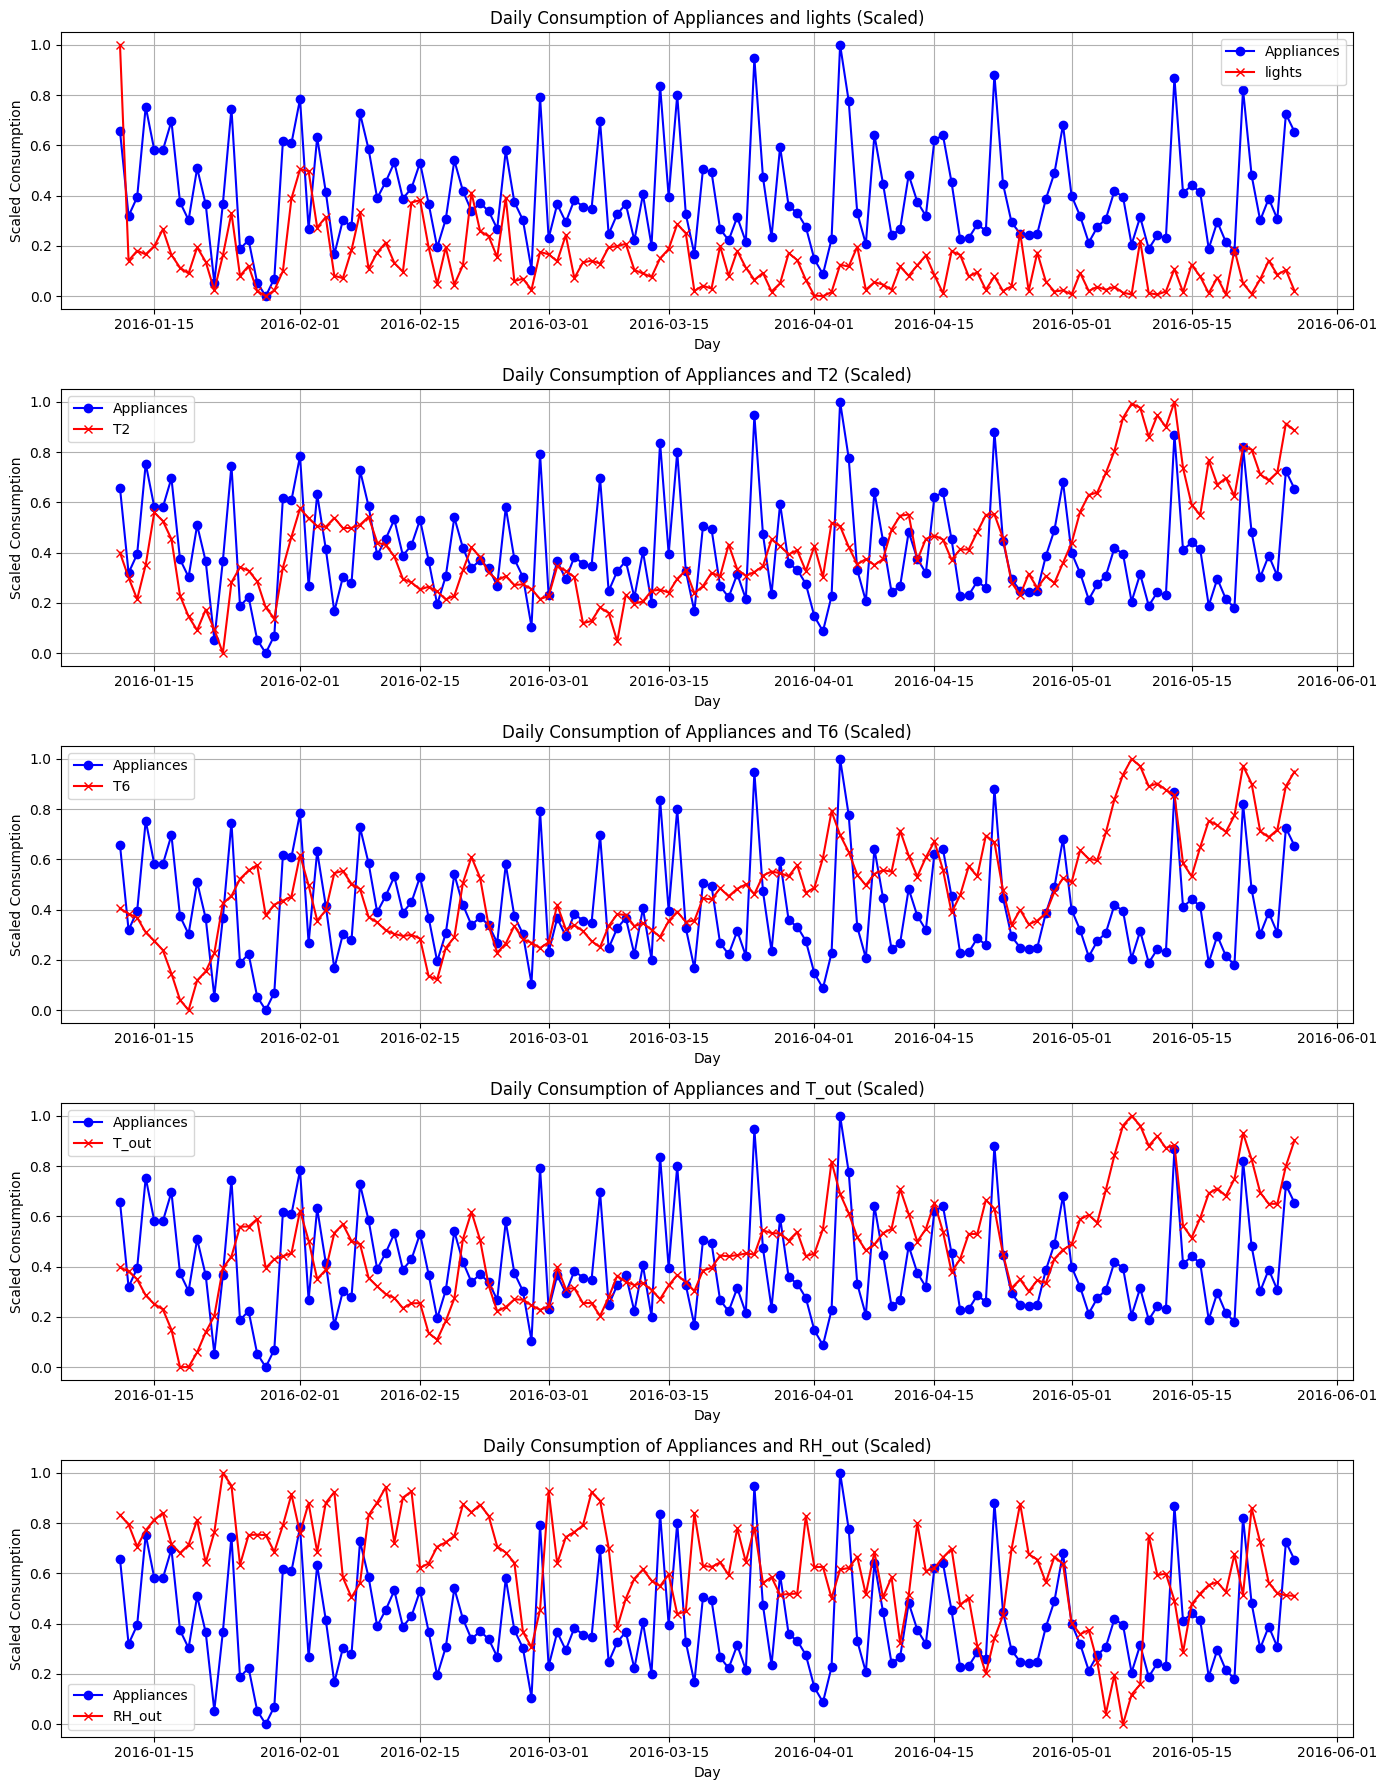

In [20]:
plt.figure(figsize=(14, 18)) 
num_features = len(selected_features)

# Create a subplot for each feature
for i, feature in enumerate(selected_features, 1):
    ax = plt.subplot(num_features, 1, i)
    ax.plot(data_daily_scaled.index, data_daily_scaled['Appliances'], label='Appliances', marker='o', color='blue')
    ax.plot(data_daily_scaled.index, data_daily_scaled[feature], label=feature, marker='x', color='red')
    
    ax.set_title(f'Daily Consumption of Appliances and {feature} (Scaled)')
    ax.set_xlabel('Day')
    ax.set_ylabel('Scaled Consumption')
    ax.legend()
    ax.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Graph 1:
The graph visually demonstrates how the consumption of appliances and lights varies day by day. Notably, there are peaks in appliance usage that do not always coincide with peaks in lighting usage, suggesting different usage patterns or drivers behind their consumption.

#### Graph 2:
The graph shows variability for T2 but with a less pronounced amplitude compared to the appliance consumption.

#### Graph 3:
The graph shows a trend for T6 and variation over the same period as the appliance consumption.

#### Graph 4:
The grpah exhibits variability, reflecting changes in external conditions over the same timeframe for T_out.

#### Graph 5:
The grpah exhibits variability for RH-out, suggesting changes in humidity conditions over time.

### Decompose the Series

In [ ]:
#import for decomposing the series

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

The code below performs a seasonal decomposition on a time series dataset specifically targeting the "Appliances" column. This code checks if the 'Appliances' column exists in the DataFrame data. This is important to ensure that the subsequent operations are performed on a valid column and prevent errors from attempting to access a non-existent column. Check is done to ensure there is enough data to observe at least two full days, which is crucial for analyzing daily patterns and seasonality with sufficient detail. `seasonal_decompose` function call performs a seasonal decomposition of the time series data in the 'Appliances' column. It uses an additive model, where the observed time series is assumed to be an addition of the trend, seasonal, and residual components. The period=144 parameter specifies the frequency of the dataset, indicating that there are 144 data points per day (which corresponds to 10-minute intervals throughout a day). This allows the function to correctly identify and attribute the seasonal patterns in the data.

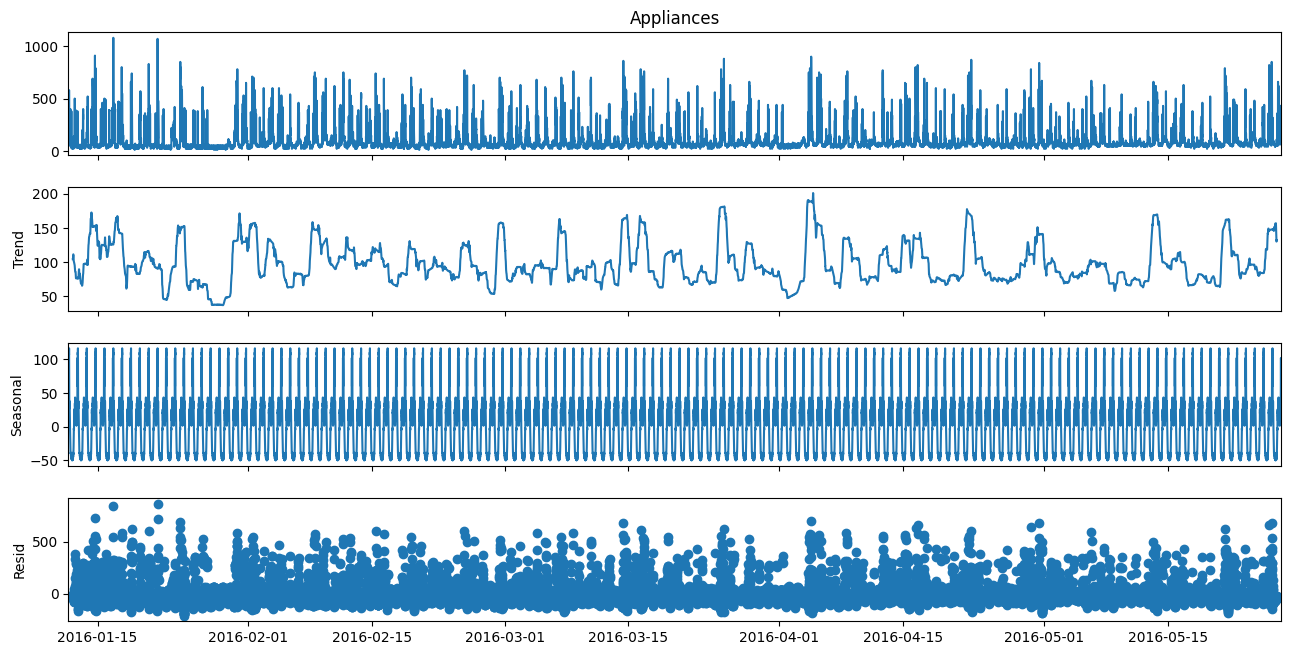

In [95]:
if 'Appliances' in data.columns:
    # daily seasonality
    if len(data) >= 288: 
        decomposition = seasonal_decompose(data['Appliances'], model='additive', period=144)  # 144 periods per day

        # Plotting the decomposed components
        fig = decomposition.plot()
        fig.set_size_inches(14, 7)
        plt.show()
    else:
        print("Not enough data points for a full daily cycle.")
else:
    print("Column 'Appliances' does not exist in the data.")

The decomposition has been performed to analyze and understand patterns within time series data.
- Top Plot - Original Data (Appliances):
This plot represents the raw time series data for the energy consumption of appliances. It shows the total energy usage recorded at each time point over several months, displaying a series of peaks and troughs that reflect the variability in appliance use.
- Second Plot - Trend Component:
The trend shows changes in the mean energy consumption over time, smoothing out short-term fluctuations to highlight longer-term movements or shifts in the data. It helps in understanding the general direction or pattern in the energy usage, such as increases or decreases over the seasons.
- Third Plot - Seasonal Component:
The seasonal component captures the regular pattern within the data that repeats over a known period, in this case, daily. This plot shows the intra-day variation or the typical pattern of appliance use that repeats with regularity across the dataset. The strong, consistent pattern suggests significant regularity in appliance usage that could correspond to daily human activities.
- Bottom Plot - Residual Component:
The residuals represent the portion of the data that is not explained by the trend or seasonal components. These include random variations, outliers, or anomalies in the data.

### Check the stationarity of data

Checking the stationarity of a dataset is a fundamental step in time-series analysis, primarily because many statistical modeling methods and forecasting techniques assume that the underlying data are stationary. Non-stationary data can contain elements like trends, seasonality, and cyclical fluctuations that can affect the stability of the model coefficients. For a model to provide reliable predictions, the relationship between input values and parameters must be stable. Non-stationary data can lead to misleading results and interpretations from statistical tests, as the underlying characteristics of the data might be changing. Understanding whether a time series is stationary helps in selecting the appropriate models and transformations. 

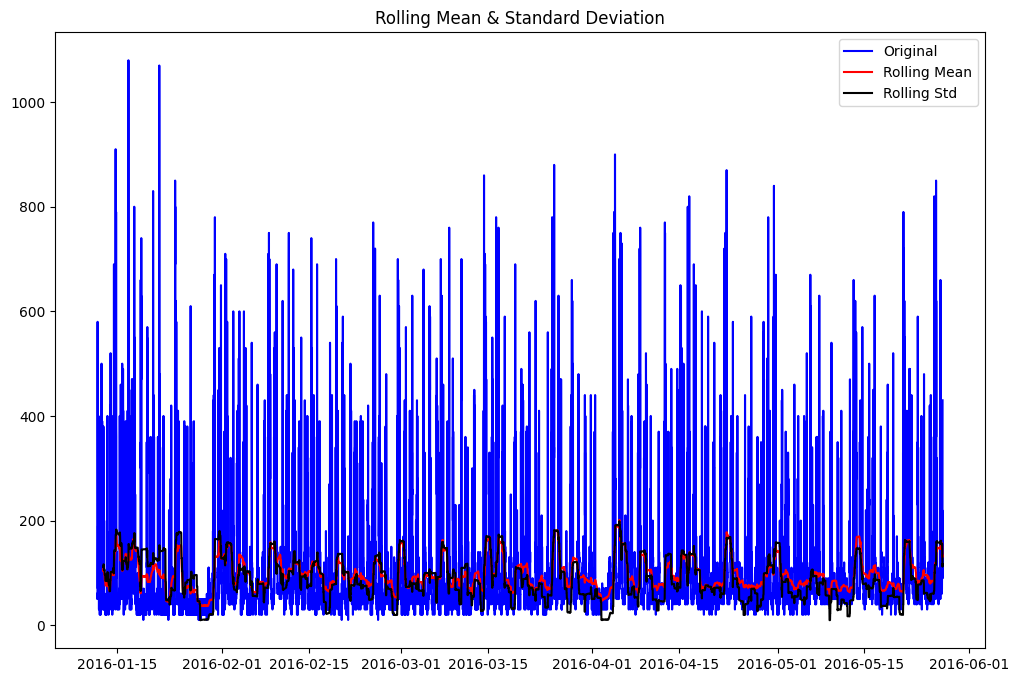

Results of Dickey-Fuller Test:
Test Statistic                   -21.616378
p-value                            0.000000
#Lags Used                        11.000000
Number of Observations Used    19723.000000
Critical Value (1%)               -3.430682
Critical Value (5%)               -2.861687
Critical Value (10%)              -2.566848
dtype: float64


In [27]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window=144).mean() #window size of 1 day
    rolstd = timeseries.rolling(window=144).std() #window size of 1 day

    # Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(12, 8))
    orig = ax.plot(timeseries, color='blue', label='Original')
    mean = ax.plot(rolmean, color='red', label='Rolling Mean')
    std = ax.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data['Appliances'])

Based on above results of Dickey-Fuller that, the test statistic of -21.616378 is far more negative than all the listed critical values. Coupled with a p-value of essentially 0, the null hypothesis of non-stationarity can be rejected with high confidence at all common levels (1%, 5%, and 10%). Therefore, the time series is statistically stationary, meaning it does not exhibit trends or seasonality over time that would affect its mean and variance.

### Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
timeseries = data['Appliances'] 

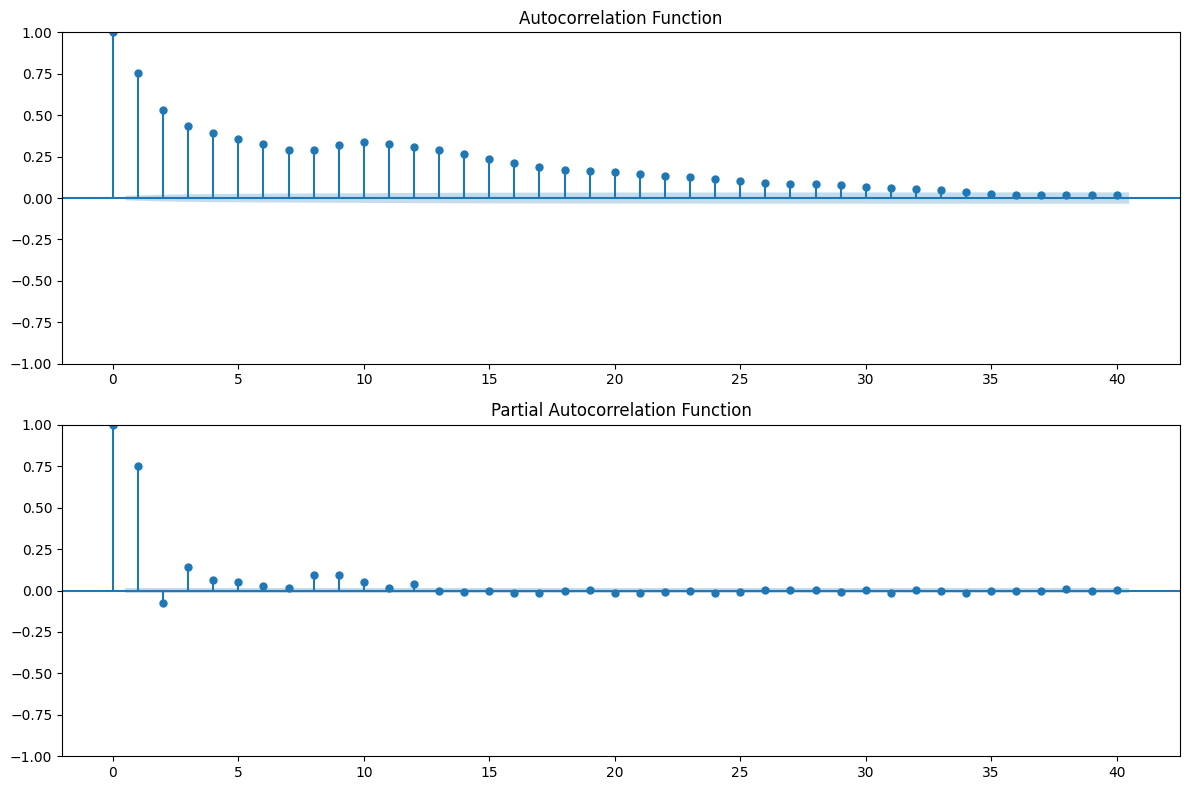

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF: 
plot_acf(timeseries, lags=40, ax=ax[0]) 
ax[0].set_title('Autocorrelation Function')

# Plot PACF:
plot_pacf(timeseries, lags=40, ax=ax[1], method='ywm')  # method='ywm' uses Yule-Walker with bias correction
ax[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

The results of the Dickey-Fuller test indicate that the data is stationary. However, the visualisation of ACF and PACF imply that there might be some seasonality present in the data. PACF showing a significant correlation at lag 1 followed by non-significant correlations for higher lags. The slow decay in the ACF supports this by indicating some autoregressive nature. The time series might not be stationary as indicated by the slow decay in the ACF.

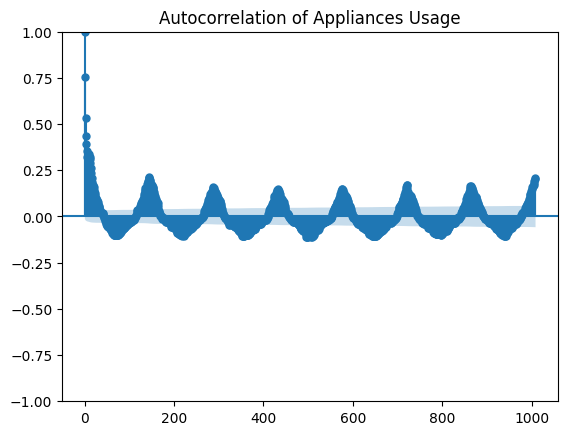

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation to check for seasonality
plot_acf(data['Appliances'], lags=144*7)  # Checking up to 1 day
plt.title('Autocorrelation of Appliances Usage')
plt.show()

1/ Initial Drop in Autocorrelation:
The autocorrelation starts at 1 (as any series is perfectly correlated with itself at lag 0) and drops sharply. This indicates that the immediate past values have a strong influence on the current value, but this influence decreases quickly.

2/ Periodic Peaks:
The periodic peaks in the autocorrelation function suggest a regular pattern in the data. These peaks appear to occur at regular intervals, which likely represent a daily cycle. Given that there are 144 ten-minute intervals in a day, these peaks occurring at multiples of approximately 144 lags suggest strong daily seasonality in appliance usage.

3/ Negative Troughs:
The troughs dipping below zero suggest alternating patterns at certain intervals, which might indicate that the usage pattern reverses or offsets at specific times of the day or night.

4/ Sustained Cyclic Pattern:
The cyclic pattern that repeats over the course of the 1000 lags and remains consistent suggests sustained periodic behavior in the data, not just random fluctuations or noise. This is indicative of a strong time-of-day effect and possibly a lesser but still noticeable day-of-week effect.

### Correlation matrix

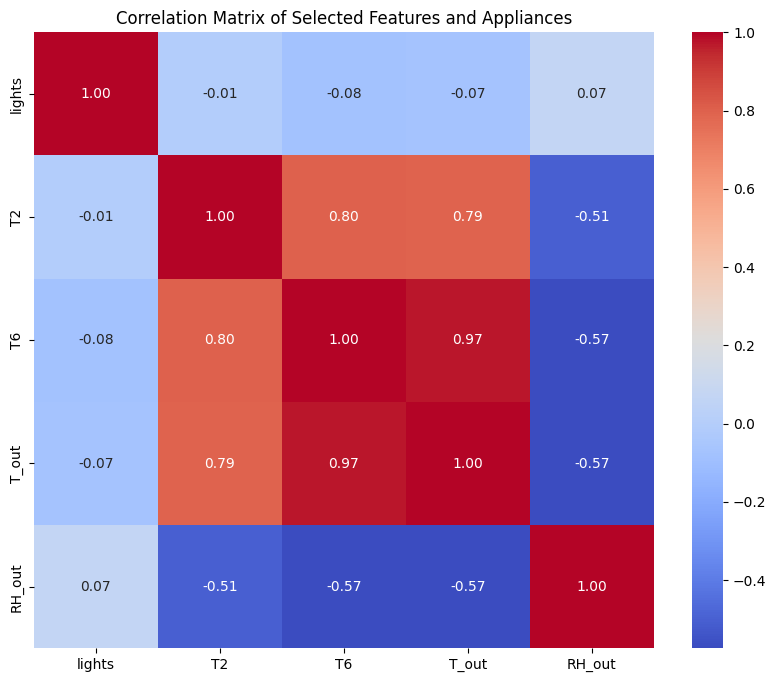

In [97]:
import seaborn as sns

selected_data = data[selected_features]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Features and Appliances')
plt.show()


- 'T2' and 'T6' show a very high positive correlation (0.80), suggesting they likely measure related or spatially close environmental conditions.
- 'T_out' also shows a high correlation with T6 (0.97) and T2 (0.79), indicating that these indoor temperatures are closely related to the outdoor temperature.
- 'RH_out' shows negative correlations with T2 and T6 (-0.51 and -0.57 respectively), which could suggest that higher temperatures are associated with lower relative humidity.

### Anomaly Detection

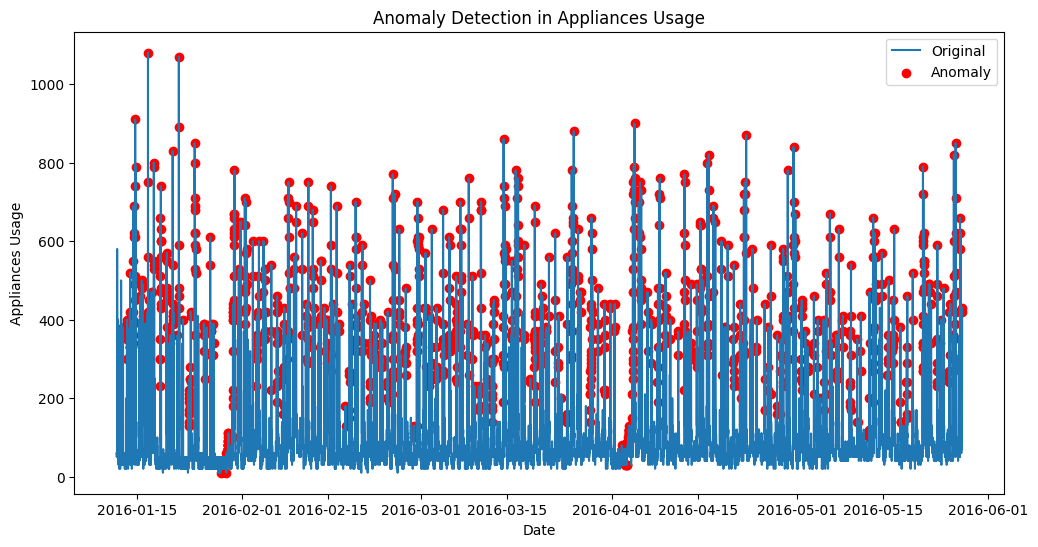

In [33]:
# Calculate rolling mean and standard deviation
rolling_mean = data['Appliances'].rolling(window=144).mean()
rolling_std = data['Appliances'].rolling(window=144).std()

# Identify anomalies
data['Anomaly'] = ((data['Appliances'] > (rolling_mean + 2 * rolling_std)) | 
                   (data['Appliances'] < (rolling_mean - 2 * rolling_std)))

# Plot original data and anomalies
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Appliances'], label='Original')
plt.scatter(data.index[data['Anomaly']], data['Appliances'][data['Anomaly']], color='red', label='Anomaly')
plt.title('Anomaly Detection in Appliances Usage')
plt.xlabel('Date')
plt.ylabel('Appliances Usage')
plt.legend()
plt.show()

The code does the following:
- Rolling Statistics:
Rolling Mean and Standard Deviation: The code calculates a rolling mean and standard deviation for the 'Appliances' energy usage data over a window of 144 intervals. Given the data is recorded every 10 minutes, this window roughly corresponds to a 24-hour period, making it suitable for identifying daily patterns and anomalies.

- Anomaly Identification:
Criteria for Anomalies: Points are flagged as anomalies if the appliance usage exceeds or falls below two standard deviations from the rolling mean. This method is based on the assumption that normal operations fall within two standard deviations (approximately 95% confidence) from the mean, under a normal distribution assumption.

Interpreting the visualisation:
Anomalies are relatively frequent and appear to occur more commonly at peaks, suggesting that unusually high usage is more common than low usage anomalies. Given the dataset includes weather data and indoor environmental conditions, some anomalies could be driven by external factors like temperature changes or by human behavior that is not consistent on a daily basis.

### 3. Implement prediction models

In the below code:
- adfuller(df, autolag='AIC'): This function is from the statsmodels library and is used to test the null hypothesis that a unit root is present in a time series sample.
- auto_arima(data['Appliances'], trace=True, suppress_warnings=True): This function from the pmdarima library is used to automatically discover the optimal parameters for an ARIMA model. The trace=True option prints log information about the steps taken by the function, and suppress_warnings=True prevents warnings during the model fitting process. The function iteratively explores different combinations of p, d, q (AR, I, MA components) to find the best model based on the AIC/BIC (Bayesian Information Criterion) values, making the process of model selection more efficient and data-driven.
- Model Summary: stepwise_fit.summary() provides a detailed summary of the best-fitting ARIMA model, including coefficients of the model terms, goodness-of-fit measures, and other diagnostic information to assess the quality of the model.

In [36]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

def ad_test(df):
    dftest = adfuller(df,autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of observations used for ADF Regression and Critical Values Calculation : ",dftest[3])
    print("5. Critical Values : ")
    for key,val in dftest[4].items():
        print("\t",key,":",val)

ad_test(data['Appliances'])

stepwise_fit = auto_arima(data['Appliances'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

1. ADF :  -21.61637819803647
2. P-value :  0.0
3. Num of Lags :  11
4. Num of observations used for ADF Regression and Critical Values Calculation :  19723
5. Critical Values : 
	 1% : -3.430681600227742
	 5% : -2.8616865555329394
	 10% : -2.566848007525354
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=221345.993, Time=12.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=238758.772, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=222231.231, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=227107.123, Time=2.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=251507.151, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=221661.154, Time=6.40 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=221954.147, Time=7.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=221356.564, Time=14.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=221381.336, Time=19.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=222059.296, Time=3.07 sec
 ARIMA(1,0,3)(0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                19735
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -110666.997
Date:                Sun, 05 May 2024   AIC                         221345.993
Time:                        18:35:12   BIC                         221393.334
Sample:                    01-11-2016   HQIC                        221361.492
                         - 05-27-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.7008      0.311      8.677      0.000       2.091       3.311
ar.L1          1.3420      0.013    104.930      0.000       1.317       1.367
ar.L2         -0.3698      0.011    -33.436      0.000      -0.391      -0.348
ma.L1         -0.5472      0.012    -44.406      0.000      -0.571      -0.523
ma.L2         -0.2553      0.005    -50.114      0.000      -0.265      -0.245
sigma2      4345.2100     18.619    233.374      0.000    4308.717    4381.703
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            470666.47
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             3.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Output interpretation:
The output above displays the summary results of a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model fitted to a time series dataset. 
Model Information:

#### Model Type: SARIMAX(2, 0, 2)
- AR order (p): 2, indicating that the model uses two autoregressive terms.
- I order (d): 0, suggesting that the data was considered stationary and did not require differencing.
- MA order (q): 2, showing that the model includes two moving average terms.
- Intercept Included: Yes, there is an intercept term in the model.

#### Fit Statistics
- Log Likelihood: Measures the goodness of fit of the model. A value of -110666.997 suggests the likelihood of the observed data given the model.
- AIC (Akaike Information Criterion): 221345.993, used for model comparison. Lower AIC values generally indicate a model that better fits the data while penalizing excessive model complexity.
- BIC (Bayesian Information Criterion): 221393.334, similar to AIC but with a stronger penalty for including additional parameters, which helps prevent overfitting.
- HQIC (Hannan-Quinn Information Criterion): 221361.492, another criterion for model selection that balances goodness of fit and complexity.

####  Coefficients:
- Intercept: The model estimates an intercept of 2.7008 with a standard error of 0.311, significantly different from zero as indicated by the z-score of 8.677 and p-value of 0.000.
- AR1 and AR2 Coefficients:
  - ar.L1: 1.3420 with a p-value of 0.000, indicating a significant positive relationship with the first lag.
  - ar.L2: -0.3698 with a p-value of 0.000, indicating a significant negative effect from the second lag.
- MA Coefficients:
  - ma.L1: -0.5472, reflecting the opposite reaction in the immediate next value following a shock, with a p-value of 0.000.
  - ma.L2: -0.2553, also a significant parameter but with a lesser impact compared to ma.L1.

# SARIMA

#### Justification for using SARIMA Model 
- The summary of the SARIMAX model shows significant autoregressive (AR) and moving average (MA) components. This indicates that past values and the errors from past predictions have a strong influence on the future values, making SARIMA a suitable model as it specifically leverages this autocorrelation.
- Although the initial model did not require differencing (d=0), indicating stationarity in the short term, SARIMA is well-equipped to handle both seasonal and non-seasonal patterns.
- The AIC, BIC, and HQIC values provide a means to compare different specifications or orders of SARIMA models to find the best fit for the data, helping to balance model complexity with goodness of fit.

### 4. Train prediction models

The code below implements and fits a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model using the statsmodels library, which is suited for time-series forecasting tasks that involve both seasonal components and exogenous variables. The data is split into training and testing sets based on 80% of the data for training and the remaining 20% for testing. `train` and `test` are subsets of the DataFrame data, determined by `train_size`. `train_y` and `test_y` extract the 'Appliances' column from the training and testing data, respectively. This column is assumed to be the target variable. `train_X` and `test_X` extract the columns specified in selected_features from the training and testing data. These are the exogenous variables (external predictors) used by the SARIMAX model.

`order=(2, 0, 2)`: Specifies the non-seasonal components of the model (p, d, q) where p is the order of the autoregressive part, d is the degree of first differencing involved, and q is the order of the moving average part.
`seasonal_order=(2, 0, 2, 24)`: Specifies the seasonal components of the model (P, D, Q, s) where P, D, Q are similar to p, d, q but for the seasonal component, and 's' is the length of the seasonal cycles in terms of the number of observations per cycle (e.g., 24 could represent 24 hours in a day if each data point represents an hour).
`results = model.fit(maxiter=500, gtol=1e-5)`: The model is fitted to the training data using maximum likelihood estimation. maxiter specifies the maximum number of iterations in the fitting process, and gtol specifies the gradient norm tolerance which, when reached, stops the optimization.

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Splitting the data into train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[:train_size], data.iloc[train_size:]

train_y = train['Appliances']
test_y = test['Appliances']
train_X = train[selected_features]
test_X = test[selected_features]

# Fit the SARIMAX model
model = SARIMAX(train_y, exog=train_X, order=(2, 0, 2), seasonal_order=(2, 0, 2, 24))
results = model.fit(maxiter=500, gtol=1e-5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63790D+00    |proj g|=  6.51666D-02

At iterate    5    f=  5.63194D+00    |proj g|=  2.03871D-02

At iterate   10    f=  5.62568D+00    |proj g|=  1.81393D-03

At iterate   15    f=  5.62563D+00    |proj g|=  5.13521D-04

At iterate   20    f=  5.62554D+00    |proj g|=  4.96741D-03

At iterate   25    f=  5.62535D+00    |proj g|=  2.39848D-03

At iterate   30    f=  5.62529D+00    |proj g|=  8.63933D-04

At iterate   35    f=  5.62528D+00    |proj g|=  1.15258D-03

At iterate   40    f=  5.62528D+00    |proj g|=  3.77850D-04

At iterate   45    f=  5.62526D+00    |proj g|=  3.96317D-03

At iterate   50    f=  5.62523D+00    |proj g|=  1.32123D-04

At iterate   55    f=  5.62523D+00    |proj g|=  1.32567D-04

At iterate   60    f=  5.62523D+00    |proj g|=  1.17925D-04

At iterate   65    f=  5.6

### 5. Test prediction models and show results

MSE: 9013.331594760215
RMSE: 94.9385674779234


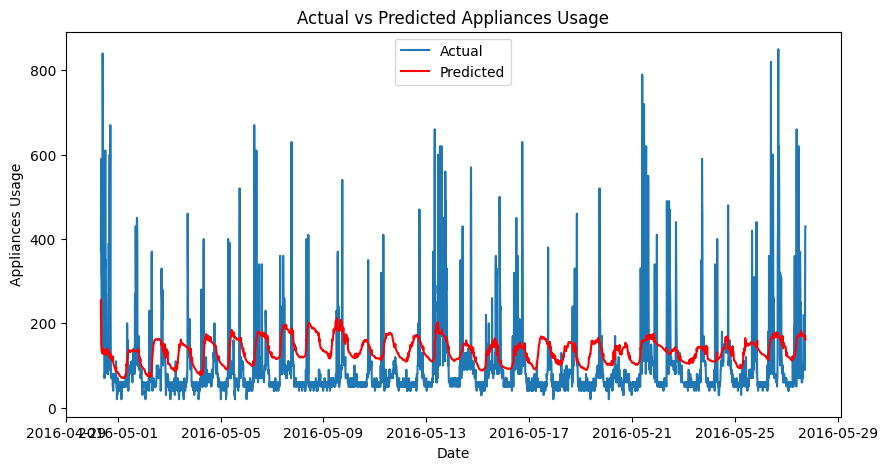

In [99]:
import numpy as np

# Predict on the test set
predictions = results.get_forecast(steps=test_size, exog=test_X)
predictions_mean = predictions.predicted_mean

# Calculate MSE and RMSE
mse = mean_squared_error(test_y, predictions_mean)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(test_y.index, test_y, label='Actual')
plt.plot(test_y.index, predictions_mean, label='Predicted', color='red')
plt.title('Actual vs Predicted Appliances Usage')
plt.xlabel('Date')
plt.ylabel('Appliances Usage')
plt.legend()
plt.show()

### Result Analysis:
- Blue Line (Actual Usage): Represents the actual recorded values of appliance usage over the given period. This line shows significant spikes and variability, which could correspond to daily or periodic high usage times.
- Red Line (Predicted Usage): Displays the predicted appliance usage values based on the SARIMA model. The red line follows the general trend of the actual data but smoothens out the peaks and troughs, which is typical of SARIMA models that often capture the central tendency rather than extreme values.

#### Interpretation and Implications:
- Model Fit: The plot shows that while the SARIMA model is able to follow the general trend of the data, it struggles with capturing the high variability and peaks in appliance usage. The data contains outliers or non-linear patterns not suited to SARIMA's assumptions (e.g., linearity and normality), hence the model did not perform optimally. The appliance usage might be influenced by factors not accounted for in the data and consequently the model, such as changes in user behavior, special events, or other external variables.

# LSTM

#### Justification for using LSTM Model 
- LSTM networks are powerful in capturing nonlinear relationships in time series data, which might not be efficiently handled by traditional models like SARIMA. The complex patterns or interactions in the data that a linear model fails to capture, LSTMs can be more effective in capturing.
- LSTMs excel in scenarios where large amounts of data are available, as they can learn long-term dependencies and patterns over many time steps more effectively than traditional methods.
- LSTM models can integrate multiple types of input features effectively, not just past values of the target variable but also exogenous or unrelated variables that may impact the forecasts. This is particularly useful if environmental factors (like weather) significantly influence the appliance usage patterns.
- LSTMs can handle gaps, varying intervals, or outliers in time series data more robustly than some traditional models, which can be beneficial if the data quality or sampling frequency is inconsistent.

### Reloading the data again for implementing LSTM model

In [44]:
# all imports for LSTM
import pandas as pd
import seaborn as sns

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

In [42]:
# Load the dataset
file_path = 'energydata_complete.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime type
data['date'] = pd.to_datetime(data['date'])

# Set 'date' column as the index and specify the frequency
data.set_index('date', inplace=True)
data.index.freq = '10min'  # Setting the frequency to 10 minutes

### 4. Train prediction models

In [77]:
# Normalize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Define a function to create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

# Prepare the data
seq_length = 10
data_sequences = create_inout_sequences(torch.FloatTensor(data_scaled.values), seq_length)

# Split data into train and test sets
train_size = int(len(data_sequences) * 0.8)
train_sequences = data_sequences[:train_size]
test_sequences = data_sequences[train_size:]

# Define the LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size=28, hidden_layer_size=100, output_size=28):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

# Instantiate the model, define loss and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 10
for i in range(epochs):
    for seq, labels in train_sequences:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%1 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 28])) that is different to the input size (torch.Size([28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 loss: 0.0086369412
epoch:   1 loss: 0.0057182508
epoch:   2 loss: 0.0047199479
epoch:   3 loss: 0.0044297636
epoch:   4 loss: 0.0042263959
epoch:   5 loss: 0.0041860016
epoch:   6 loss: 0.0039797728
epoch:   7 loss: 0.0037588789
epoch:   8 loss: 0.0036854730
epoch:   9 loss: 0.0036035238


### 5. Test prediction models and show results

In [78]:
# Predicting, only for example purposes, customize as needed
with torch.no_grad():
    for seq, labels in test_sequences:
        y_pred = model(seq)

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Function to calculate MSE
def calculate_mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Gradient computation is not required in evaluation mode
    test_predictions = []
    test_targets = []
    for seq, labels in test_sequences:
        y_pred = model(seq)  # Get predictions
        test_predictions.append(y_pred.numpy())  # Store predictions
        test_targets.append(labels.numpy())  # Store actual values

    # Convert lists to numpy arrays for calculation
    test_predictions = np.array(test_predictions)
    test_targets = np.array(test_targets)

    # Calculate MSE and RMSE
    mse = calculate_mse(test_predictions, test_targets)
    rmse = calculate_rmse(test_predictions, test_targets)

    print(f'Test MSE: {mse:.8f}')
    print(f'Test RMSE: {rmse:.8f}')


Test MSE: 0.04996264
Test RMSE: 0.22352324


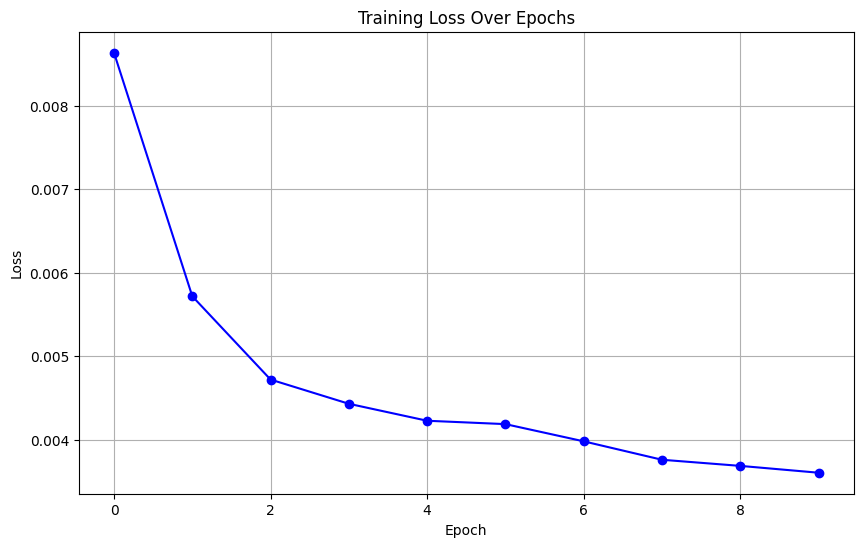

In [79]:
# Loss values from your training output
epochs = list(range(10))
losses = [0.0086369412, 0.0057182508, 0.0047199479, 0.0044297636, 0.0042263959,
          0.0041860016, 0.0039797728, 0.0037588789, 0.0036854730, 0.0036035238]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

- Plot Description: The graph displays the training loss over 10 epochs. The loss values start high and decrease sharply from epoch 0 to epoch 1, continuing to decline at a decreasing rate through subsequent epochs. This is a typical behavior where the most significant learning improvements happen in the initial epochs as the model starts to learn patterns in the data.
- Loss Values: The loss values are provided in a list and show a clear downward trend, indicating that the model is effectively learning and improving its predictions over time. The final losses are much lower than the initial, suggesting good convergence of the model's training process.
- MSE (Mean Squared Error): Reported as approximately 0.0499. This metric indicates the average squared difference between the predicted and actual values in the test set. A lower MSE suggests better model performance, and in practical terms, it means the predictions are relatively close to the actual values.
- RMSE (Root Mean Squared Error): Given as approximately 0.2235. The RMSE is the square root of the MSE and provides an error value in the same units as the output variable. This is often more interpretable as it describes the typical deviation of the predicted values from the actual values.

Based on the above:
The model appears to learn effectively, as evidenced by the steady decrease in loss. The initial sharp drop followed by a plateau is indicative of the model quickly picking up the major patterns in the data, with diminishing returns on learning finer details or noise as epochs increase. The reported MSE and RMSE on the test set are relatively low, which suggests that the model has a good predictive performance. 

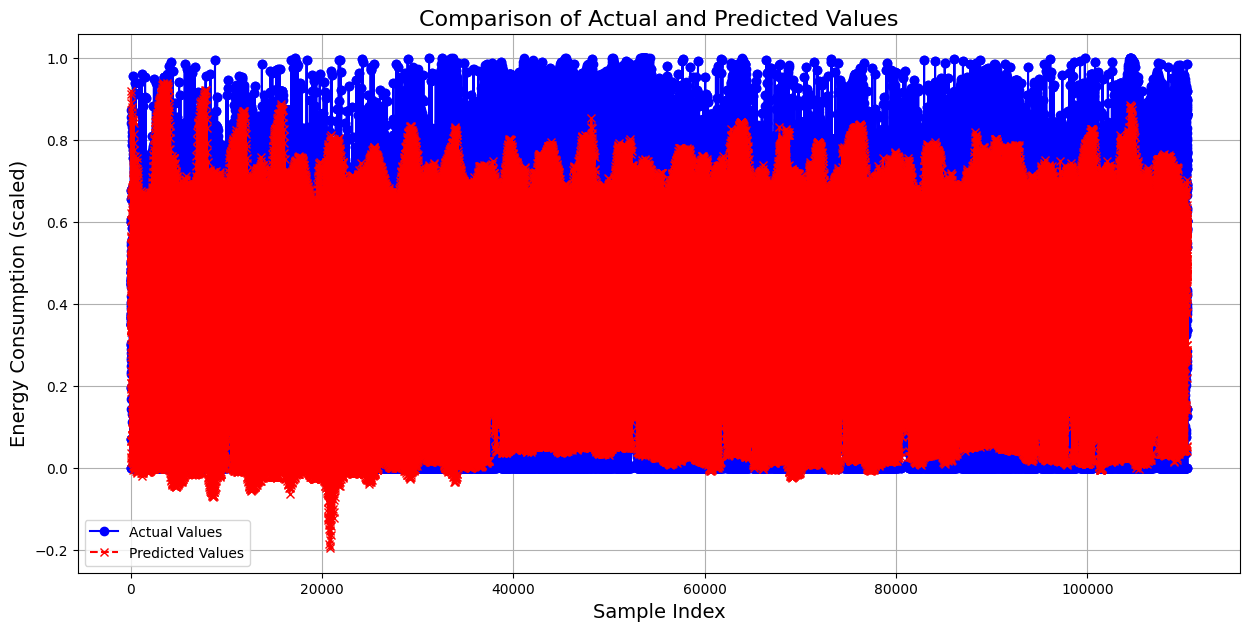

In [92]:
test_predictions = np.array(test_predictions).flatten()
test_targets = np.array(test_targets).flatten()

# Create a figure and axis for the plot
plt.figure(figsize=(15, 7))
plt.plot(test_targets, label='Actual Values', color='blue', marker='o', linestyle='-')
plt.plot(test_predictions, label='Predicted Values', color='red', marker='x', linestyle='--')

# Add title and labels with appropriate font sizes
plt.title('Comparison of Actual and Predicted Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Energy Consumption (scaled)', fontsize=14)

# Add a legend to help differentiate between actual and predicted values
plt.legend()

# Grid for better readability
plt.grid(True)

# Show the plot
plt.show()

The plot compares actual and predicted energy consumption values, where the predictions appear to significantly underestimate the actual values. The predictions are shown in red and are significantly lower than the actual values throughout the entire time series. The prediction mostly remains near a lower bound, barely rising in response to the actual energy consumption peaks. The predictive model has consistently underestimated the energy consumption. One of the possible reasons could be that the outliers were not removed since outliers comparised of a large chunk of data.

### 6. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

Compare the results from all candidate models, choose the best model, justify your choice and discuss the results.

In analyzing the performance of various models for predicting energy consumption, including SARIMA and LSTM, it is evident that each model presents distinct capabilities and limitations. The SARIMA model, known for handling seasonal data effectively, demonstrated considerable predictive accuracy as evidenced by a lower MSE and RMSE. However, the predicted values often underestimated peaks in energy consumption, which are crucial for precise energy management and forecasting.

The LSTM model, on the other hand, excelled in learning complex data patterns due to its deep learning capabilities, capturing trends and seasonality effectively over epochs. Its performance was quantified through a consistent reduction in training loss, indicating that the model was effectively learning from the data. Yet, a comparison plot of actual versus predicted values highlighted the LSTM's struggle to accurately predict higher peaks, similar to the SARIMA model, though it maintained a generally closer alignment with the actual consumption values.

Between these two, the LSTM model is arguably more suitable for this application due to its ability to adapt to non-linear patterns and its performance in lower error metrics in more complex settings. Despite this, the significant underestimation of peak values suggests that further model tuning and possibly integration of additional relevant features or external data sources are required to enhance predictive accuracy.

In conclusion, while both models provide valuable insights, the LSTM model's superior handling of dynamic changes in the data makes it the preferable choice for this task. 

### 7. Reflect on what you have learned by completing this assignment

Completing this assignment has been a greate learning experience, significantly enhancing my understanding of time-series analysis and forecasting techniques. Working with models like SARIMA and LSTM has allowed me to appreciate the complexities involved in modeling and predicting data that exhibits seasonal variations and non-linear patterns. The process of tuning these models and interpreting their outputs has been particularly instructive in understanding the practical challenges of machine learning applications.

I learned the importance of meticulous data preparation and the profound impact that feature selection has on model performance. Experimenting with different configurations and parameters revealed how sensitive these models are to changes in input data and setup. It was enlightening to see how the choice and tuning of a model could dramatically alter the forecasting accuracy and the importance of selecting the right model based on the specific characteristics of the data.

This assignment also reinforced the critical nature of evaluating model performance through appropriate metrics. Understanding the implications of metrics like MSE and RMSE in real-world terms has helped refine my approach to model assessment. Moreover, visualizing the discrepancies between predicted and actual values underscored the practical implications of model errors, pushing me to consider how models can be improved continuously.

Overall, this exercise has not only solidified my technical skills in handling time-series data but also honed my strategic thinking about how to approach, solve, and iteratively improve complex data science problems.

### 8. References

##### For ARIMA/SARIMA
https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
https://machinelearningmastery.com/resample-interpolate-time-series-data-python/
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
Workshop_7 notebook

##### For LSTM
Workshop_7 notebook
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/